## comma package tutorial

In [1]:
from comma.model import Model
from comma import create_empty_hypotheses
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option('display.max_columns', None)
np.random.seed(0)
dir_params = '../parameters/'

# Create empty matrices in `dir_params` folder

Store in the `dir_params` directory folder templates of the matrices. The templates are all empty (i.e., made of 0s) and serve the purpose of providing a ready-to-be-filled guide for the user to specify their hypotheses about both the type of lockdown, and the effects of each action on the mental health and number of contacts.

In [2]:
create_empty_hypotheses(dir_params)

### Initialize agents with some example hypotheses

For demonstration purposes, we load now from the `parameters_example` directory folder the matrices containing some of the hypotheses that we have made up. We also specify a population made of 100 agents.

### Initialise the model and generate 100 individuals

In [3]:
model = Model()

In [4]:
size = 100
individuals = model.setup(size, '../parameters_example/')

### Run the model

This will output "simulation_results.csv". You can define the type of lockdown (among "hard", "easy", "medium", "no_lockdown") for each number of steps.

In [8]:
lockdowns = ['absent', 'easy', 'medium', 'hard']
steps = 10
# at the moment we are randomising it but ideally one should give the sequence of lockdowns for each step
repeated_entries = lockdowns * (steps // len(lockdowns)) + lockdowns[:steps % len(lockdowns)]
randomised_lockdowns = random.sample(repeated_entries, len(repeated_entries))

In [9]:
model.run(steps=steps, lockdown=randomised_lockdowns, out_path="simulation_results.csv")

In [10]:
data = pd.read_csv('simulation_results.csv')

### Group by step_id and compute the average mh and n_contacts

In [11]:
display(data.head())

,step_id,agent_id,lockdown,mh,n_contacts
0,0,0,absent,5.0,5.8
1,0,1,absent,5.5,4.5
2,0,2,absent,-1.0,1.9
3,0,3,absent,3.0,1.4
4,0,4,absent,7.0,7.9


In [12]:
grouped_data = data.groupby('lockdown').mean()[['mh', 'n_contacts']]

In [13]:
grouped_data = data.groupby(['step_id', 'lockdown']).mean().reset_index()
display(grouped_data.head())

,step_id,lockdown,agent_id,mh,n_contacts
0,0,absent,49.5,4.990,5.414
1,1,hard,49.5,3.675,4.139
2,2,absent,49.5,5.045,5.378
3,3,medium,49.5,4.265,4.661
4,4,easy,49.5,4.855,5.675


### Create a scatter plot of the average mh and n_contacts for each step coloured by lockdown type

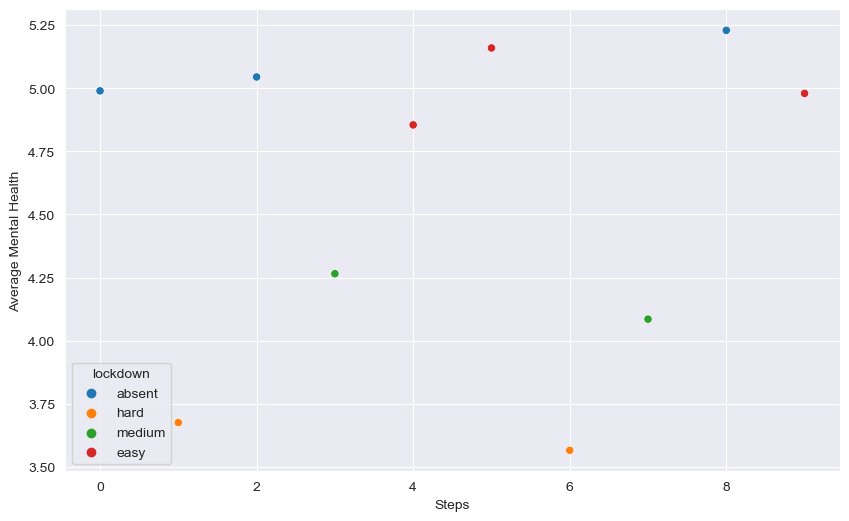

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=grouped_data, x='step_id', y='mh', hue='lockdown')
plt.xlabel('Steps')
plt.ylabel('Average Mental Health')
plt.show()

In [15]:
data.groupby(['lockdown']).mean().reset_index()

,lockdown,step_id,agent_id,mh,n_contacts
0,absent,3.333333,49.5,5.088333,5.597333
1,easy,6.000000,49.5,4.998333,5.736000
2,hard,3.500000,49.5,3.620000,4.078500
3,medium,5.000000,49.5,4.175000,4.805000


#### Average mental health by lockdown type

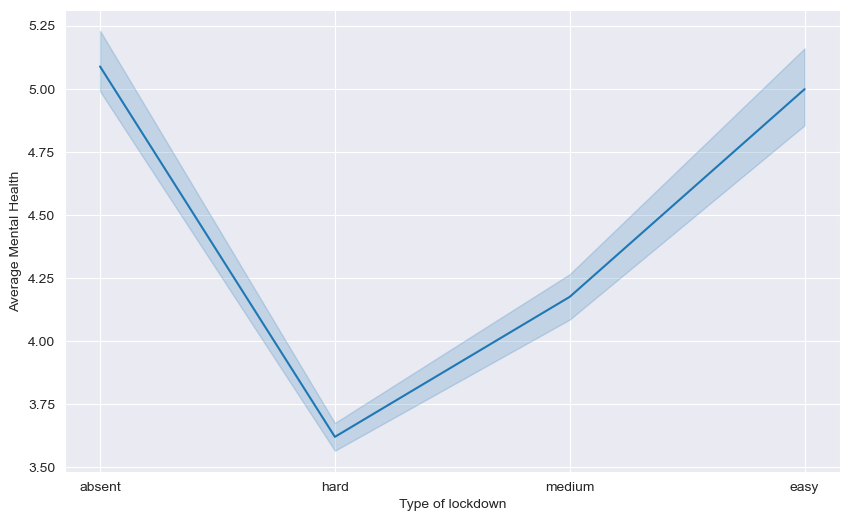

In [16]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped_data, x="lockdown", y="mh")
plt.xlabel('Type of lockdown')
plt.ylabel('Average Mental Health')
plt.show()